In [2]:
#https://github.com/rixwew/pytorch-fm/tree/master/torchfm
#https://www.kaggle.com/gennadylaptev/factorization-machine-implemented-in-pytorch
#https://nagornyy.me/courses/recommendation-systems/factorization-machines-pytorch/

In [3]:
import numpy as np
import pandas as pd
import torch.utils.data
import torch
import torch.nn.functional as F

import torch
import tqdm
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Factorisation machine

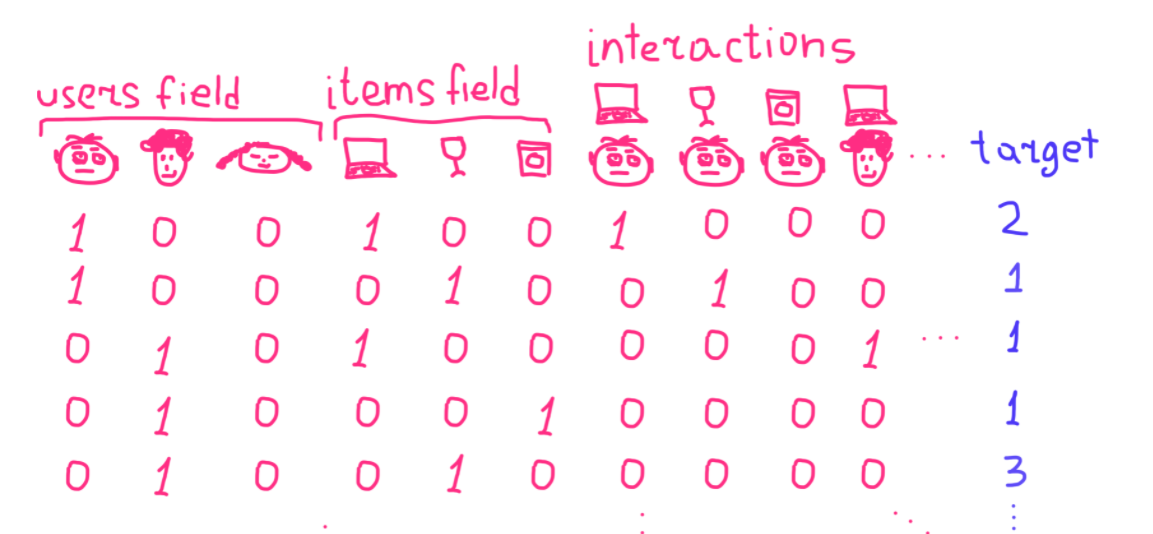

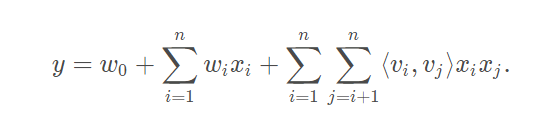

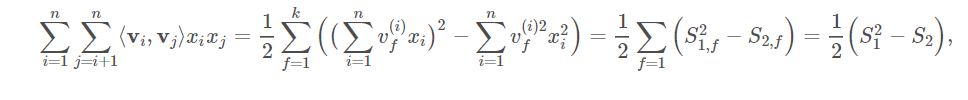

## Data

In [4]:
movielens = pd.read_csv('./data/ml-latest-small/ratings.csv', sep=',', engine='python', header='infer')

In [5]:
tags = pd.read_csv('./data/ml-latest-small/tags.csv', sep=',', engine='python', header='infer')

In [6]:
movie = pd.read_csv('./data/ml-latest-small/movies.csv', sep=',', engine='python', header='infer')

In [7]:
movielens.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [21]:
tags = tags.groupby(['userId', 'movieId'])['tag'].agg(list).reset_index()
tags.head()

,userId,movieId,tag
0,2,60756,"[funny, Highly quotable, will ferrell]"
1,2,89774,"[Boxing story, MMA, Tom Hardy]"
2,2,106782,"[drugs, Leonardo DiCaprio, Martin Scorsese]"
3,7,48516,[way too long]
4,18,431,"[Al Pacino, gangster, mafia]"


In [16]:
mb = MultiLabelBinarizer()

In [26]:
tags = tags[["userId", "movieId"]].join(pd.DataFrame(mb.fit_transform(tags["tag"]), columns=mb.classes_))

In [28]:
print("shape before merging ", movielens.shape)
#movielens = movielens.merge(movie, on = ["movieId"])
movielens = movielens.merge(tags, on = ["userId", "movieId"], how='left')
print("shape after merging ", movielens.shape)

shape before merging  (100836, 4)
shape after merging  (100836, 1593)


In [29]:
#number of unique
movielens.iloc[:,:2].nunique().values

array([ 610, 9724])

In [197]:
class MovieLens1MDataset(torch.utils.data.Dataset):
    """
    MovieLens 20M Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    :param dataset_path: MovieLens dataset path
    Reference:
        https://grouplens.org/datasets/movielens
    """

    def __init__(self, data, sep=',', engine='python', header='infer', type_data = 'train'):
        #data = pd.read_csv(dataset_path, sep=sep, engine=engine, header=header)
        
        self.user2id = {key: i for i, key in enumerate(np.unique(data['userId']))}
        self.item2id = {key: i for i, key in enumerate(np.unique(data['movieId']))}
        self.tag2id = {key: i for i, key in enumerate(np.unique(data['tag']))}
        
        data['userId'] = data['userId'].map(self.user2id)
        data['movieId'] = data['movieId'].map(self.item2id)
        data['tag'] = data['tag'].map(self.tag2id)
               
        numpy_data = data.to_numpy()
        self.items = numpy_data[:, :3].astype(np.int) 
        print(self.items)
        self.targets = self.__preprocess_target(numpy_data[:, -1]).astype(np.float32)
        print(self.targets)
        self.field_dims = np.max(self.items, axis=0) + 1
        
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s').dt.to_period('Y').astype('str').astype(int)
        
        if type_data == 'train':
            numpy_data = data[data['timestamp']<2015].to_numpy()[:, :3]
            self.items = numpy_data[:, :2].astype(np.int)  
            self.targets = self.__preprocess_target(numpy_data[:, 2]).astype(np.float32)                                                                    
        elif  type_data == 'valid':
            numpy_data = data[data['timestamp'].isin([2017])].to_numpy()[:, :3]
            self.items = numpy_data[:, :2].astype(np.int)  
            self.targets = self.__preprocess_target(numpy_data[:, 2]).astype(np.float32)
        elif  type_data == 'test':
            numpy_data = data[data['timestamp']==2018].to_numpy()[:, :3]
            self.items = numpy_data[:, :2].astype(np.int)  
            self.targets = self.__preprocess_target(numpy_data[:, 2]).astype(np.float32)
        
        
        self.user_field_idx = np.array((0, ), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 3] = 0
        target[target > 3] = 1
        return target

In [198]:
movielens.head()

,userId,movieId,rating,timestamp,tag
0,1,1,4.0,964982703,NaN
1,1,3,4.0,964981247,NaN
2,1,6,4.0,964982224,NaN
3,1,47,5.0,964983815,NaN
4,1,50,5.0,964982931,NaN


In [199]:
dataset = MovieLens1MDataset(movielens.fillna({"tag":"NAN"}))[["userId", "movieId", "tag", "timestamp", "rating"]]

[[   0    0    4]
 [   0    2    4]
 [   0    5    4]
 ...
 [ 609 9444    5]
 [ 609 9445    5]
 [ 609 9485    3]]
[1. 1. 1. ... 1. 1. 1.]


/home/sergei_modvala/miniconda3/envs/pml/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Number of unique values
dataset.field_dims

### Factorization machine model

In [31]:
class FactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Factorization Machine.
    Reference:
        S Rendle, Factorization Machines, 2010.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = self.linear(x) + self.fm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

In [32]:
class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        #print("FeaturesLinear - fc", self.fc)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        #print("FeaturesLinear - bias", self.bias)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        #print("FeaturesLinear offset size - ", self.offsets)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias


class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        #print("FeaturesEmbedding ", self.embedding)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        #print("FeaturesEmbedding offset size - ", self.offsets.shape)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

In [33]:
class FactorizationMachine(torch.nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix

In [34]:
FactorizationMachineModel([3, 3, 4], 5)

FactorizationMachineModel(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(10, 5)
  )
  (linear): FeaturesLinear(
    (fc): Embedding(10, 1)
  )
  (fm): FactorizationMachine()
)

#### Utils

In [46]:
import os
from 

In [63]:
class EarlyStopper(object):

    def __init__(self, num_trials, path, filename):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_accuracy = 0
        self.path = path
        self.filename = filename

    def is_continuable(self, model, accuracy):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.trial_counter = 0
            
            if not os.path.exists(self.path):
                os.mkdir(self.path)
            torch.save(model, os.path.join(self.path, self.filename))
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False

In [64]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            tk0.set_postfix(loss=total_loss / log_interval)
            total_loss = 0

In [65]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return roc_auc_score(targets, predicts)

#### Training

In [74]:
def main(dataset_path,
         model_name,
         validataion_by_time,
         epoch,
         learning_rate,
         batch_size,
         weight_decay,
         device,
         save_dir
        ):
    device = torch.device(device)
    if validataion_by_time:
        train_dataset = MovieLens1MDataset(dataset_path,  type_data = 'train')
        valid_dataset = MovieLens1MDataset(dataset_path,  type_data = 'valid')
        test_dataset = MovieLens1MDataset(dataset_path,  type_data = 'test')
        field_dims = train_dataset.field_dims
    else:
        dataset = MovieLens1MDataset(dataset_path, type_data = 'None')
        train_length = int(len(dataset) * 0.8)
        valid_length = int(len(dataset) * 0.1)
        test_length = len(dataset) - train_length - valid_length
        train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
            dataset, (train_length, valid_length, test_length))
        field_dims = dataset.field_dims
        
    
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)
    
    #field_dims = train_dataset.field_dims
    model = FactorizationMachineModel(field_dims, embed_dim=64).to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    early_stopper = EarlyStopper(num_trials=2, path=f'{save_dir}', filename = '{model_name}.pt')
    for epoch_i in range(epoch):
        train(model, optimizer, train_data_loader, criterion, device)
        auc = test(model, valid_data_loader, device)
        print('epoch:', epoch_i, 'validation: auc:', auc)
        if not early_stopper.is_continuable(model, auc):
            print(f'validation: best auc: {early_stopper.best_accuracy}')
            break
    auc = test(model, test_data_loader, device)
    print(f'test auc: {auc}')

In [75]:
main(dataset_path='./data/ml-latest-small/ratings.csv',
     model_name='fm',
     validataion_by_time = True,
     epoch=3,
    learning_rate=0.008,
    batch_size=128,
    weight_decay=0.001,
    device='cpu',
     save_dir='./model'
    )

  0%|          | 0/570 [00:00<?, ?it/s]

epoch: 0 validation: auc: 0.6360323909624183


  0%|          | 0/570 [00:00<?, ?it/s]

epoch: 1 validation: auc: 0.644970353203838


  0%|          | 0/51 [00:00<?, ?it/s]

epoch: 2 validation: auc: 0.6441539159348093


100%|██████████| 51/51 [00:00<00:00, 124.30it/s]

test auc: 0.6160500255070119


# Instacart

In [ ]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['user_id', 'product_id', 'rating', 'timestamp']
            else:
                columns = ['product_id', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
    return files['ratings'], files['products']

from pathlib import Path

DATA = Path('./data/instacart-market-basket-analysis/')

aisles = pd.read_csv(DATA / 'aisles' / 'aisles.csv')
print(aisles.shape)
aisles.head()

product = pd.read_csv(DATA / 'products' / 'products.csv')
product = product.merge(aisles)
print(product.shape)
product.head()

orders = pd.read_csv(DATA / 'orders' / 'orders.csv')
print(orders.shape)
orders.head()

order_product = pd.read_csv(DATA / 'order_products__prior' / 'order_products__prior.csv')
print(order_product.shape)
order_product.head()

order_product.product_id.nunique()

orders_user = order_product.merge(orders, on = ['order_id'])

filtered_users = orders_user.query("reordered==1").groupby(['user_id', 'product_id'])['reordered'].sum().reset_index()\
    .query("reordered>2")['user_id'].unique()

In [141]:
order_product_sample = order_product[order_product['product_id']\
                                     .isin(product.query("aisle_id in (1,2,3)")['product_id'].unique())]
print(order_product_sample.shape)

order_sample = order_product_sample.merge(orders, on=['order_id'])
order_sample = order_sample[order_sample['user_id'].isin(filtered_users)]
print(order_sample.shape)

print('users', order_sample.user_id.nunique())
print('product', order_sample.product_id.nunique())

(610805, 4)
(581611, 10)
users 78048
product 1248


In [144]:
order_sample.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,4,39758,3,1,178520,prior,36,1,9,7.0
1,5,47329,3,1,156122,prior,42,6,16,9.0
2,80,42118,3,1,190599,prior,16,3,13,7.0
3,88,2067,7,1,102020,prior,4,0,11,7.0
4,93,13194,1,0,130239,prior,15,6,10,19.0


In [153]:
order_sample_product = order_sample.merge(product, on= ['product_id'])

In [154]:
order_sample_product.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle
0,4,1004,3,1,67621,prior,36,1,9,7.0,Vitamin E Moisture Rich Shampoo for Dry or Dam...,22,11,hair care
1,927,1004,1,1,42826,prior,2,1,12,22.0,Vitamin E Moisture Rich Shampoo for Dry or Dam...,22,11,hair care
2,1782,1004,2,0,15410,prior,5,6,19,30.0,Vitamin E Moisture Rich Shampoo for Dry or Dam...,22,11,hair care
3,2719,1004,21,0,33383,prior,7,0,15,4.0,Vitamin E Moisture Rich Shampoo for Dry or Dam...,22,11,hair care
4,3445,1004,6,0,10326,prior,12,6,12,7.0,Vitamin E Moisture Rich Shampoo for Dry or Dam...,22,11,hair care


In [155]:
class InstacartDataset(torch.utils.data.Dataset):
    """
    Instacart dataset
    """

    def __init__(self, data, type_data = 'train', add_columns = None):
        self.add_columns = [] if add_columns is None else add_columns
        
        self.user2id = {key: i for i, key in enumerate(np.unique(data['user_id']))}
        self.item2id = {key: i for i, key in enumerate(np.unique(data['product_id']))}
        self.col2id = {}
        for col in self.add_columns:
            self.col2id[col] = {key: i for i, key in enumerate(np.unique(data[col]))}
        
        data['user_id'] = data['user_id'].map(self.user2id)
        data['product_id'] = data['product_id'].map(self.item2id)
        
        for col in self.add_columns:
            data[col] = data[col].map(self.col2id[col])
               
        numpy_data = data[['product_id', 'user_id']+self.add_columns].to_numpy()
        self.items = numpy_data.astype(np.int) 
        self.targets = data['reordered'].values.astype('float32')
        self.field_dims = np.max(self.items, axis=0) + 1
        
        
        self.user_field_idx = np.array((0, ), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

### Training

In [156]:
def main(dataset_path,
         model_name,
         epoch,
         learning_rate,
         batch_size,
         weight_decay,
         device,
         save_dir
        ):
    device = torch.device(device)
    dataset = InstacartDataset(data = order_sample_product, add_columns = ['aisle_id', 'department_id'])
    train_length = int(len(dataset) * 0.8)
    valid_length = int(len(dataset) * 0.1)
    test_length = len(dataset) - train_length - valid_length
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))
    field_dims = dataset.field_dims
        
    
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)
    
    #field_dims = train_dataset.field_dims
    model = FactorizationMachineModel(field_dims, embed_dim=16).to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    early_stopper = EarlyStopper(num_trials=2, save_path=f'{save_dir}/{model_name}.pt')
    for epoch_i in range(epoch):
        train(model, optimizer, train_data_loader, criterion, device)
        auc = test(model, valid_data_loader, device)
        print('epoch:', epoch_i, 'validation: auc:', auc)
        if not early_stopper.is_continuable(model, auc):
            print(f'validation: best auc: {early_stopper.best_accuracy}')
            break
    auc = test(model, test_data_loader, device)
    print(f'test auc: {auc}')

In [152]:
main(dataset_path='./data/ml-latest-small/ratings.csv',
     model_name='fm',
     epoch=3,
    learning_rate=0.01,
    batch_size=128,
    weight_decay=0.001,
    device='cpu',
     save_dir='./model'
    )

  0%|          | 0/3636 [00:00<?, ?it/s]

epoch: 0 validation: auc: 0.6112572902775084


  0%|          | 0/3636 [00:00<?, ?it/s]

epoch: 1 validation: auc: 0.6112509970720306


  0%|          | 0/455 [00:00<?, ?it/s]

epoch: 2 validation: auc: 0.6112514585737657
validation: best auc: 0.6112572902775084


100%|██████████| 455/455 [00:03<00:00, 145.86it/s]


test auc: 0.6043560440924789


In [157]:
main(dataset_path='./data/ml-latest-small/ratings.csv',
     model_name='fm',
     epoch=3,
    learning_rate=0.01,
    batch_size=128,
    weight_decay=0.001,
    device='cpu',
     save_dir='./model'
    )

  0%|          | 0/3623 [00:00<?, ?it/s]

epoch: 0 validation: auc: 0.5844833219446108


  0%|          | 0/3623 [00:00<?, ?it/s]

epoch: 1 validation: auc: 0.5826669256226971


  0%|          | 0/453 [00:00<?, ?it/s]

epoch: 2 validation: auc: 0.5835713585087234
validation: best auc: 0.5844833219446108


100%|██████████| 453/453 [00:01<00:00, 286.67it/s]

test auc: 0.5834331494508811


# Field Aware FM

In [161]:
class FieldAwareFactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Field-aware Factorization Machine.
    Reference:
        Y Juan, et al. Field-aware Factorization Machines for CTR Prediction, 2015.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.ffm = FieldAwareFactorizationMachine(field_dims, embed_dim)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        ffm_term = torch.sum(torch.sum(self.ffm(x), dim=1), dim=1, keepdim=True)
        x = self.linear(x) + ffm_term
        return torch.sigmoid(x.squeeze(1))

In [162]:
class FieldAwareFactorizationMachine(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.num_fields = len(field_dims)
        self.embeddings = torch.nn.ModuleList([
            torch.nn.Embedding(sum(field_dims), embed_dim) for _ in range(self.num_fields)
        ])
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        for embedding in self.embeddings:
            torch.nn.init.xavier_uniform_(embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        xs = [self.embeddings[i](x) for i in range(self.num_fields)]
        ix = list()
        for i in range(self.num_fields - 1):
            for j in range(i + 1, self.num_fields):
                ix.append(xs[j][:, i] * xs[i][:, j])
        ix = torch.stack(ix, dim=1)
        return ix

In [163]:
def main(dataset_path,
         model_name,
         epoch,
         learning_rate,
         batch_size,
         weight_decay,
         device,
         save_dir
        ):
    device = torch.device(device)
    dataset = InstacartDataset(data = order_sample_product, add_columns = ['aisle_id', 'department_id'])
    train_length = int(len(dataset) * 0.8)
    valid_length = int(len(dataset) * 0.1)
    test_length = len(dataset) - train_length - valid_length
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))
    field_dims = dataset.field_dims
        
    
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)
    
    #field_dims = train_dataset.field_dims
    model = FieldAwareFactorizationMachine(field_dims, embed_dim=16).to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    early_stopper = EarlyStopper(num_trials=2, save_path=f'{save_dir}/{model_name}.pt')
    for epoch_i in range(epoch):
        train(model, optimizer, train_data_loader, criterion, device)
        auc = test(model, valid_data_loader, device)
        print('epoch:', epoch_i, 'validation: auc:', auc)
        if not early_stopper.is_continuable(model, auc):
            print(f'validation: best auc: {early_stopper.best_accuracy}')
            break
    auc = test(model, test_data_loader, device)
    print(f'test auc: {auc}')

In [164]:
main(dataset_path='./data/ml-latest-small/ratings.csv',
     model_name='fm',
     epoch=3,
    learning_rate=0.01,
    batch_size=128,
    weight_decay=0.001,
    device='cpu',
     save_dir='./model'
    )

  0%|          | 0/3623 [00:00<?, ?it/s]


ValueError: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 6, 16])) is deprecated. Please ensure they have the same size.